This is small project done based on Hands-on AI classes in JKU.
Here i tried to get some experiense with torch based neural networks, face and then solve vanishing gradient problem.

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import sys
import torch
import random

from distutils.version import LooseVersion
from IPython.core.display import HTML
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from typing import Optional, Sequence, Tuple, Union

here i will implement some functions which i will use later 

In [5]:
def set_seed(seed: int = 42) -> None:
    """
    Set seed for all underlying (pseudo) random number sources.

    :param seed: seed to be used
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.random.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [6]:
def load_mnist() -> pd.DataFrame:
    """
    Load MNIST data set [1].

    [1] LeCun, Y., 1998. The MNIST database of handwritten digits. http://yann.lecun.com/exdb/mnist/.

    :return: MNIST data set
    """
    mnist_data = datasets.fetch_openml(name=r'mnist_784', as_frame=True, parser="auto")
    data = pd.DataFrame(mnist_data["data"]).astype(np.float32)
    data["digit"] = mnist_data["target"].astype(int)
    return data

In [7]:
def split_data(data: pd.DataFrame, test_size: float) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split data set into training and testing subsets.

    :param data: data set to split
    :param test_size: relative size of the test subset
    :return: training as well as testing subsets
    """
    assert (data is not None) and (type(data) == pd.DataFrame)
    assert (test_size is not None) and (type(test_size) == float) and (0 < test_size < 1)
    return train_test_split(data, test_size=test_size)

In [8]:
def apply_pca(data: pd.DataFrame, n_components: Optional[int] = None, target_column: Optional[str] = None,
              components: Optional[PCA] = None, return_components: bool = False
              ) -> Union[Tuple[pd.DataFrame, PCA], pd.DataFrame]:
    """
    Apply principal component analysis (PCA) on specified dataset and down-project project data accordingly.

    :param data: dataset to down-project
    :param n_components: amount of (top) principal components involved in down-projection
    :param target_column: if specified, append target column to resulting, down-projected data set
    :param return_components: return principal components in addition of down-projected data set
    :param components: use these principal components instead of freshly computing them
    :return: down-projected data set and optionally principal components
    """
    assert type(data) == pd.DataFrame
    assert ((n_components is None) and (components is not None)) or (type(n_components) == int) and (n_components >= 1)
    assert ((type(target_column) == str) and (target_column in data)) or (target_column is None)
    assert (components is None) or (type(components) == PCA)
    assert type(return_components) == bool
    
    if target_column is not None:
        target_data = data[target_column]
        data = data.drop(columns=target_column)
    
    if components is None:
        components = PCA(n_components=n_components).fit(data)
    projected_data = pd.DataFrame(components.transform(data), index=data.index)
    if target_column is not None:
        projected_data[target_column] = target_data
    
    return (projected_data, components) if return_components else projected_data

In [9]:
def apply_tsne(n_components: int, data: pd.DataFrame, target_column: Optional[str] = None,
               perplexity: float = 10.0) -> pd.DataFrame:
    """
    Apply t-distributed stochastic neighbor embedding (t-SNE) on specified dataset and down-project data accordingly.

    :param n_components: dimensionality of the embedding space
    :param data: dataset to down-project
    :param target_column: if specified, append target column to resulting, down-projected dataset
    :param perplexity: this term is closely related to the number of nearest neighbors to consider
    :return: down-projected dataset
    """
    assert (type(n_components) == int) and (n_components >= 1)
    assert type(data) == pd.DataFrame
    assert ((type(target_column) == str) and (target_column in data)) or (target_column is None)
    assert (type(perplexity) == float) or (type(perplexity) == int)
    if target_column is not None:
        projected_data = pd.DataFrame(TSNE(n_components=n_components, perplexity=float(perplexity), learning_rate=200,
                                           init="random").fit_transform(data.drop(columns=target_column)),
                                      index=data.index)
        projected_data[target_column] = data[target_column]
    else:
        projected_data = pd.DataFrame(TSNE(n_components=n_components, perplexity=float(perplexity), learning_rate=200,
                                           init="random").fit_transform(data), index=data.index)
    return projected_data

In [11]:
def collect_gradients(model: torch.nn.Module, loader: torch.utils.data.DataLoader,
                      device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')) -> Sequence[Dict[str, np.array]]:
    """
    Auxiliary function for collecting gradients of a corresponding model.
    
    :param model: model instance to be used for collecting gradients
    :param loader: data loader supplying the samples used for collecting gradients
    :param device: device to use for gradient collection
    :return: sequence of parameter names and gradients, averaged over all parameter elements
    """
    model.to(device)
    model_state = model.training
    model.train()
    model.zero_grad()
    
    # Iterating over the data set and computing the corresponding gradients.
    # Since we are only interested in the gradients, we can skip the optimization step.
    gradients = {}
    criterion = torch.nn.CrossEntropyLoss()
    
    for data, target in loader:
        data, target = data.float().to(device), target.long().to(device)
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
    
        # Collecting the (averaged absolute) gradients from the current model.
        for name, parameter in model.named_parameters():
            if "weight" in name and parameter.grad is not None:
                gradients.setdefault(name, []).append(parameter.grad.view(-1).abs().mean().item())
        model.zero_grad()
    
    model.train(mode=model_state)
    return gradients
    

In [19]:
def train_network(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader,
                  optimizer: torch.optim.Optimizer, device: torch.device = r'cpu') -> None:
    """
    Train specified network for one epoch on specified data loader.

    :param model: network to train
    :param data_loader: data loader to be trained on
    :param optimizer: optimizer used to train network
    :param device: device on which to train network
    """
    model.train()
    criterion = torch.nn.CrossEntropyLoss()
    for batch_index, (data, target) in enumerate(data_loader):
        data, target = data.float().to(device), target.long().to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

In [20]:
def test_network(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader,
                 device: torch.device = r'cpu') -> Tuple[float, float]:
    """
    Test specified network on specified data loader.

    :param model: network to test on
    :param data_loader: data loader to be tested on
    :param device: device on which to test network
    :return: cross-entropy loss as well as accuracy
    """
    model.eval()
    loss = 0.0
    correct = 0
    criterion = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.float().to(device), target.long().to(device)
            output = model(data)
            loss += float(criterion(output, target).item())
            pred = output.max(1, keepdim=True)[1]
            correct += int(pred.eq(target.view_as(pred)).sum().item())
    
    return loss / len(data_loader.dataset), correct / len(data_loader.dataset)


In [21]:
def train_and_evaluate(model: torch.nn.Module, optimizer: torch.optim.Optimizer, num_epochs: int,
                       loader_train: torch.utils.data.DataLoader, loader_test: torch.utils.data.DataLoader,
                       device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')) -> None:
    """
    Auxiliary function for training and evaluating a corresponding model.
    
    :param model: model instance to train and evaluate
    :param optimizer: optimizer to use for model training
    :param num_epochs: amount of epochs for model training
    :param loader_train: data loader supplying the training samples
    :param loader_test: data loader supplying the test samples
    :param device: device to use for model training and evaluation
    """
    model.to(device)
    
    for epoch in range(num_epochs):
        # Train model instance for one epoch.
        train_network(
            model=model,
            data_loader=loader_train,
            device=device,
            optimizer=optimizer
        )

        # Evaluate current model instance.
        performance = test_network(
            model=model,
            data_loader=loader_train,
            device=device
        )

        # Print result of current epoch to standard out.
        print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
              f'/ Train loss: {performance[0]:.4f} / Train accuracy: {performance[1]:.4f}')

    # Evaluate final model on test data set.
    performance = test_network(model=model, data_loader=loader_test, device=device)
    print(f'\nTest loss: {performance[0]:.4f} / Test accuracy: {performance[1]:.4f}')

i've chosen the mnist dataset as it's alredy known and matches perfect with my requirements.

In [12]:
data_mnist = load_mnist()

In [13]:
data_mnist

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,digit
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


as we can see, MNIST dataset consists of 7000 samples, where each sample is a picture 28 x 28 pixels and a label. 

In [14]:
data_train_mnist, data_test_mnist = split_data(data_mnist, 0.2)
print(f'Training subset is of size: {data_train_mnist.shape[0]}')
print(f' Testing subset is of size: {data_test_mnist.shape[0]}')

Training subset is of size: 56000
 Testing subset is of size: 14000


Here we splitted our dataset into a trainig and test sets with ratio 4:1
Next step will be to reduce dimensionality of test set by perfomming PCA with 40 components and afterwards applying t-SNE with 2 components. 

In [15]:
pca_train = apply_pca(data_train_mnist, 40)
tsne_data = apply_tsne(2, pca_train)

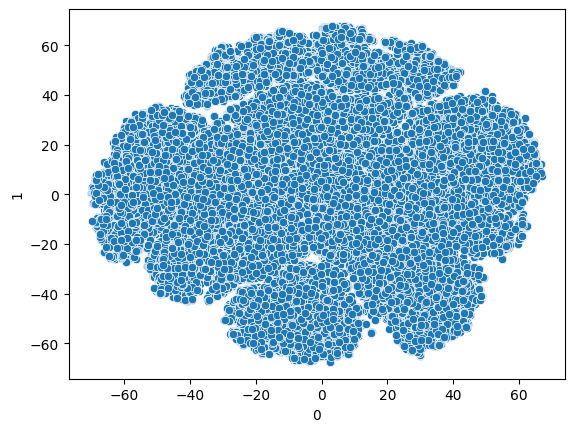

In [18]:
sns.scatterplot(x=tsne_data[0], y=tsne_data[1])
plt.show()

as we can see, applying PCA and t-SNE doesnt helped much to classify that dataset, lets try to use neural network 

Lets create a corresponding Tensor Dataset for both training and test sets 

In [22]:
loader_mnist_train = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(
        torch.from_numpy(data_train_mnist.drop(columns=['digit']).values / 255),  # normalize to range [0; 1]
        torch.from_numpy(data_train_mnist['digit'].values)
    ),
    batch_size=80,
    shuffle=True
)

In [23]:
loader_mnist_test = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(
        torch.from_numpy(data_test_mnist.drop(columns=['digit']).values / 255),  # normalize to range [0; 1]
        torch.from_numpy(data_test_mnist['digit'].values)
    ),
    batch_size=80,
    shuffle=True
)

implementing FNN with fully connected layers and sigmoid activation function 

In [24]:
class FNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(784, 512)
        self.sigm1 = torch.nn.Sigmoid()
        self.layer2 = torch.nn.Linear(self.layer1.out_features, self.layer1.out_features)
        self.sigm2 = torch.nn.Sigmoid()
        self.layer3 = torch.nn.Linear(self.layer2.out_features, self.layer2.out_features)
        self.sigm3 = torch.nn.Sigmoid()
        self.layer4 = torch.nn.Linear(self.layer3.out_features, self.layer3.out_features)
        self.sigm4 = torch.nn.Sigmoid()
        self.layer5 = torch.nn.Linear(self.layer4.out_features, self.layer4.out_features)
        self.sigm5 = torch.nn.Sigmoid()
        self.layer6 = torch.nn.Linear(self.layer5.out_features, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layer1(x)
        x = self.sigm1(x)
        x = self.layer2(x)
        x = self.sigm2(x)
        x = self.layer3(x)
        x = self.sigm3(x)
        x = self.layer4(x)
        x = self.sigm4(x)
        x = self.layer5(x)
        x = self.sigm5(x)
        return self.layer6(x)

In [25]:
fnn0 = FNN()
optimizer = torch.optim.SGD(fnn0.parameters(), lr=0.05)

fnn0

FNN(
  (layer1): Linear(in_features=784, out_features=512, bias=True)
  (sigm1): Sigmoid()
  (layer2): Linear(in_features=512, out_features=512, bias=True)
  (sigm2): Sigmoid()
  (layer3): Linear(in_features=512, out_features=512, bias=True)
  (sigm3): Sigmoid()
  (layer4): Linear(in_features=512, out_features=512, bias=True)
  (sigm4): Sigmoid()
  (layer5): Linear(in_features=512, out_features=512, bias=True)
  (sigm5): Sigmoid()
  (layer6): Linear(in_features=512, out_features=10, bias=True)
)

lets train for 6 epochs and see how it will perform 

In [26]:
train_and_evaluate(
    model=fnn0,
    optimizer=optimizer,
    num_epochs=6,
    loader_train = loader_mnist_train,
    loader_test = loader_mnist_test
)

Epoch: 1 / Train loss: 0.0289 / Train accuracy: 0.1001
Epoch: 2 / Train loss: 0.0289 / Train accuracy: 0.1001
Epoch: 3 / Train loss: 0.0288 / Train accuracy: 0.1042
Epoch: 4 / Train loss: 0.0289 / Train accuracy: 0.1042
Epoch: 5 / Train loss: 0.0288 / Train accuracy: 0.1001
Epoch: 6 / Train loss: 0.0288 / Train accuracy: 0.1131

Test loss: 0.0289 / Test accuracy: 0.1103


as we can tell from the accuracy, simple coin flip will perfom better then that nn. 
Lets look into gradients 

In [28]:
model = FNN()
gradients = (model, collect_gradients(model=model, loader=loader_mnist_train))
gradients 

(FNN(
   (layer1): Linear(in_features=784, out_features=512, bias=True)
   (sigm1): Sigmoid()
   (layer2): Linear(in_features=512, out_features=512, bias=True)
   (sigm2): Sigmoid()
   (layer3): Linear(in_features=512, out_features=512, bias=True)
   (sigm3): Sigmoid()
   (layer4): Linear(in_features=512, out_features=512, bias=True)
   (sigm4): Sigmoid()
   (layer5): Linear(in_features=512, out_features=512, bias=True)
   (sigm5): Sigmoid()
   (layer6): Linear(in_features=512, out_features=10, bias=True)
 ),
 {'layer1.weight': [7.733885354355152e-08,
   7.771470933448654e-08,
   7.575084737254656e-08,
   8.194164280439509e-08,
   7.598887918902619e-08,
   7.063623286285292e-08,
   6.704880206598318e-08,
   6.942578067992144e-08,
   7.288535641691851e-08,
   7.583253136544954e-08,
   6.945322894580386e-08,
   6.42081872115341e-08,
   9.082491914114144e-08,
   7.257686718276091e-08,
   7.231626142356617e-08,
   7.087786713100286e-08,
   7.474450569588953e-08,
   9.992884031362337e-08,
 

we can observe that gradient values are really small, but the values are different from each other, so neural network is trying to perform on the data, may be change of activation function will help. 

In [29]:
class FNN1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(784, 512)
        self.relu1 = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(self.layer1.out_features, self.layer1.out_features)
        self.relu2 = torch.nn.ReLU()
        self.layer3 = torch.nn.Linear(self.layer2.out_features, self.layer2.out_features)
        self.relu3 = torch.nn.ReLU()
        self.layer4 = torch.nn.Linear(self.layer3.out_features, self.layer3.out_features)
        self.relu4 = torch.nn.ReLU()
        self.layer5 = torch.nn.Linear(self.layer4.out_features, self.layer4.out_features)
        self.relu5 = torch.nn.ReLU()
        self.layer6 = torch.nn.Linear(self.layer5.out_features, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.layer3(x)
        x = self.relu3(x)
        x = self.layer4(x)
        x = self.relu4(x)
        x = self.layer5(x)
        x = self.relu5(x)
        return self.layer6(x)

changed activation function to Relu and again initializing instance of new nn

In [30]:
fnn1 = FNN1()
optimizer = torch.optim.SGD(fnn1.parameters(), lr=0.05)
fnn1

FNN1(
  (layer1): Linear(in_features=784, out_features=512, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=512, out_features=512, bias=True)
  (relu2): ReLU()
  (layer3): Linear(in_features=512, out_features=512, bias=True)
  (relu3): ReLU()
  (layer4): Linear(in_features=512, out_features=512, bias=True)
  (relu4): ReLU()
  (layer5): Linear(in_features=512, out_features=512, bias=True)
  (relu5): ReLU()
  (layer6): Linear(in_features=512, out_features=10, bias=True)
)

In [31]:
train_and_evaluate(
    model=fnn1,
    optimizer=optimizer,
    num_epochs=6,
    loader_train=loader_mnist_train,
    loader_test=loader_mnist_test
)

Epoch: 1 / Train loss: 0.0094 / Train accuracy: 0.7597
Epoch: 2 / Train loss: 0.0031 / Train accuracy: 0.9273
Epoch: 3 / Train loss: 0.0020 / Train accuracy: 0.9502
Epoch: 4 / Train loss: 0.0013 / Train accuracy: 0.9688
Epoch: 5 / Train loss: 0.0010 / Train accuracy: 0.9763
Epoch: 6 / Train loss: 0.0010 / Train accuracy: 0.9739

Test loss: 0.0015 / Test accuracy: 0.9624


much better! 

In [32]:
model = FNN1()
gradients = [(model, collect_gradients(model=model, loader=loader_mnist_train))]
gradients

[(FNN1(
    (layer1): Linear(in_features=784, out_features=512, bias=True)
    (relu1): ReLU()
    (layer2): Linear(in_features=512, out_features=512, bias=True)
    (relu2): ReLU()
    (layer3): Linear(in_features=512, out_features=512, bias=True)
    (relu3): ReLU()
    (layer4): Linear(in_features=512, out_features=512, bias=True)
    (relu4): ReLU()
    (layer5): Linear(in_features=512, out_features=512, bias=True)
    (relu5): ReLU()
    (layer6): Linear(in_features=512, out_features=10, bias=True)
  ),
  {'layer1.weight': [9.687918463896494e-06,
    9.642848453950137e-06,
    1.0527293852646835e-05,
    9.839542144618463e-06,
    9.903958925860934e-06,
    1.0668345566955395e-05,
    9.633928129915148e-06,
    1.0761862540675793e-05,
    1.0646537702996284e-05,
    1.0604148883430753e-05,
    1.0115451914316509e-05,
    9.911861525324639e-06,
    1.08096255644341e-05,
    1.004975911200745e-05,
    1.0556334927969147e-05,
    1.0031315468950197e-05,
    1.0605613169900607e-05,
  

here we can see that gradient has increased by 100 times at least 